In [12]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [13]:
df = pd.read_csv('splityield.txt', delimiter='\t')  # Change delimiter if needed
print(df)

    yield block irrigation density fertilizer
0      90     A    control     low          N
1      95     A    control     low          P
2     107     A    control     low         NP
3      92     A    control  medium          N
4      89     A    control  medium          P
..    ...   ...        ...     ...        ...
67    131     D  irrigated  medium          P
68    126     D  irrigated  medium         NP
69    116     D  irrigated    high          N
70    136     D  irrigated    high          P
71    133     D  irrigated    high         NP

[72 rows x 5 columns]


In [14]:
# Scale the continuous variable
scaler = StandardScaler()
df['yield_scaled'] = scaler.fit_transform(df[['yield']])

encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_vars = ['block', 'irrigation', 'density', 'fertilizer']
encoded = encoder.fit_transform(df[categorical_vars])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())

data_encoded = pd.concat([df[['yield','yield_scaled']], encoded_df], axis=1)

print(data_encoded.head())


   yield  yield_scaled  block_B  block_C  block_D  irrigation_irrigated  \
0     90     -0.535231      0.0      0.0      0.0                   0.0   
1     95     -0.259969      0.0      0.0      0.0                   0.0   
2    107      0.400658      0.0      0.0      0.0                   0.0   
3     92     -0.425126      0.0      0.0      0.0                   0.0   
4     89     -0.590283      0.0      0.0      0.0                   0.0   

   density_low  density_medium  fertilizer_NP  fertilizer_P  
0          1.0             0.0            0.0           0.0  
1          1.0             0.0            0.0           1.0  
2          1.0             0.0            1.0           0.0  
3          0.0             1.0            0.0           0.0  
4          0.0             1.0            0.0           1.0  


In [15]:
data_encoded = data_encoded.rename(columns={'yield': 'yield_value'})
print(data_encoded.isnull().sum())

yield_value             0
yield_scaled            0
block_B                 0
block_C                 0
block_D                 0
irrigation_irrigated    0
density_low             0
density_medium          0
fertilizer_NP           0
fertilizer_P            0
dtype: int64


## Correlation Matrix

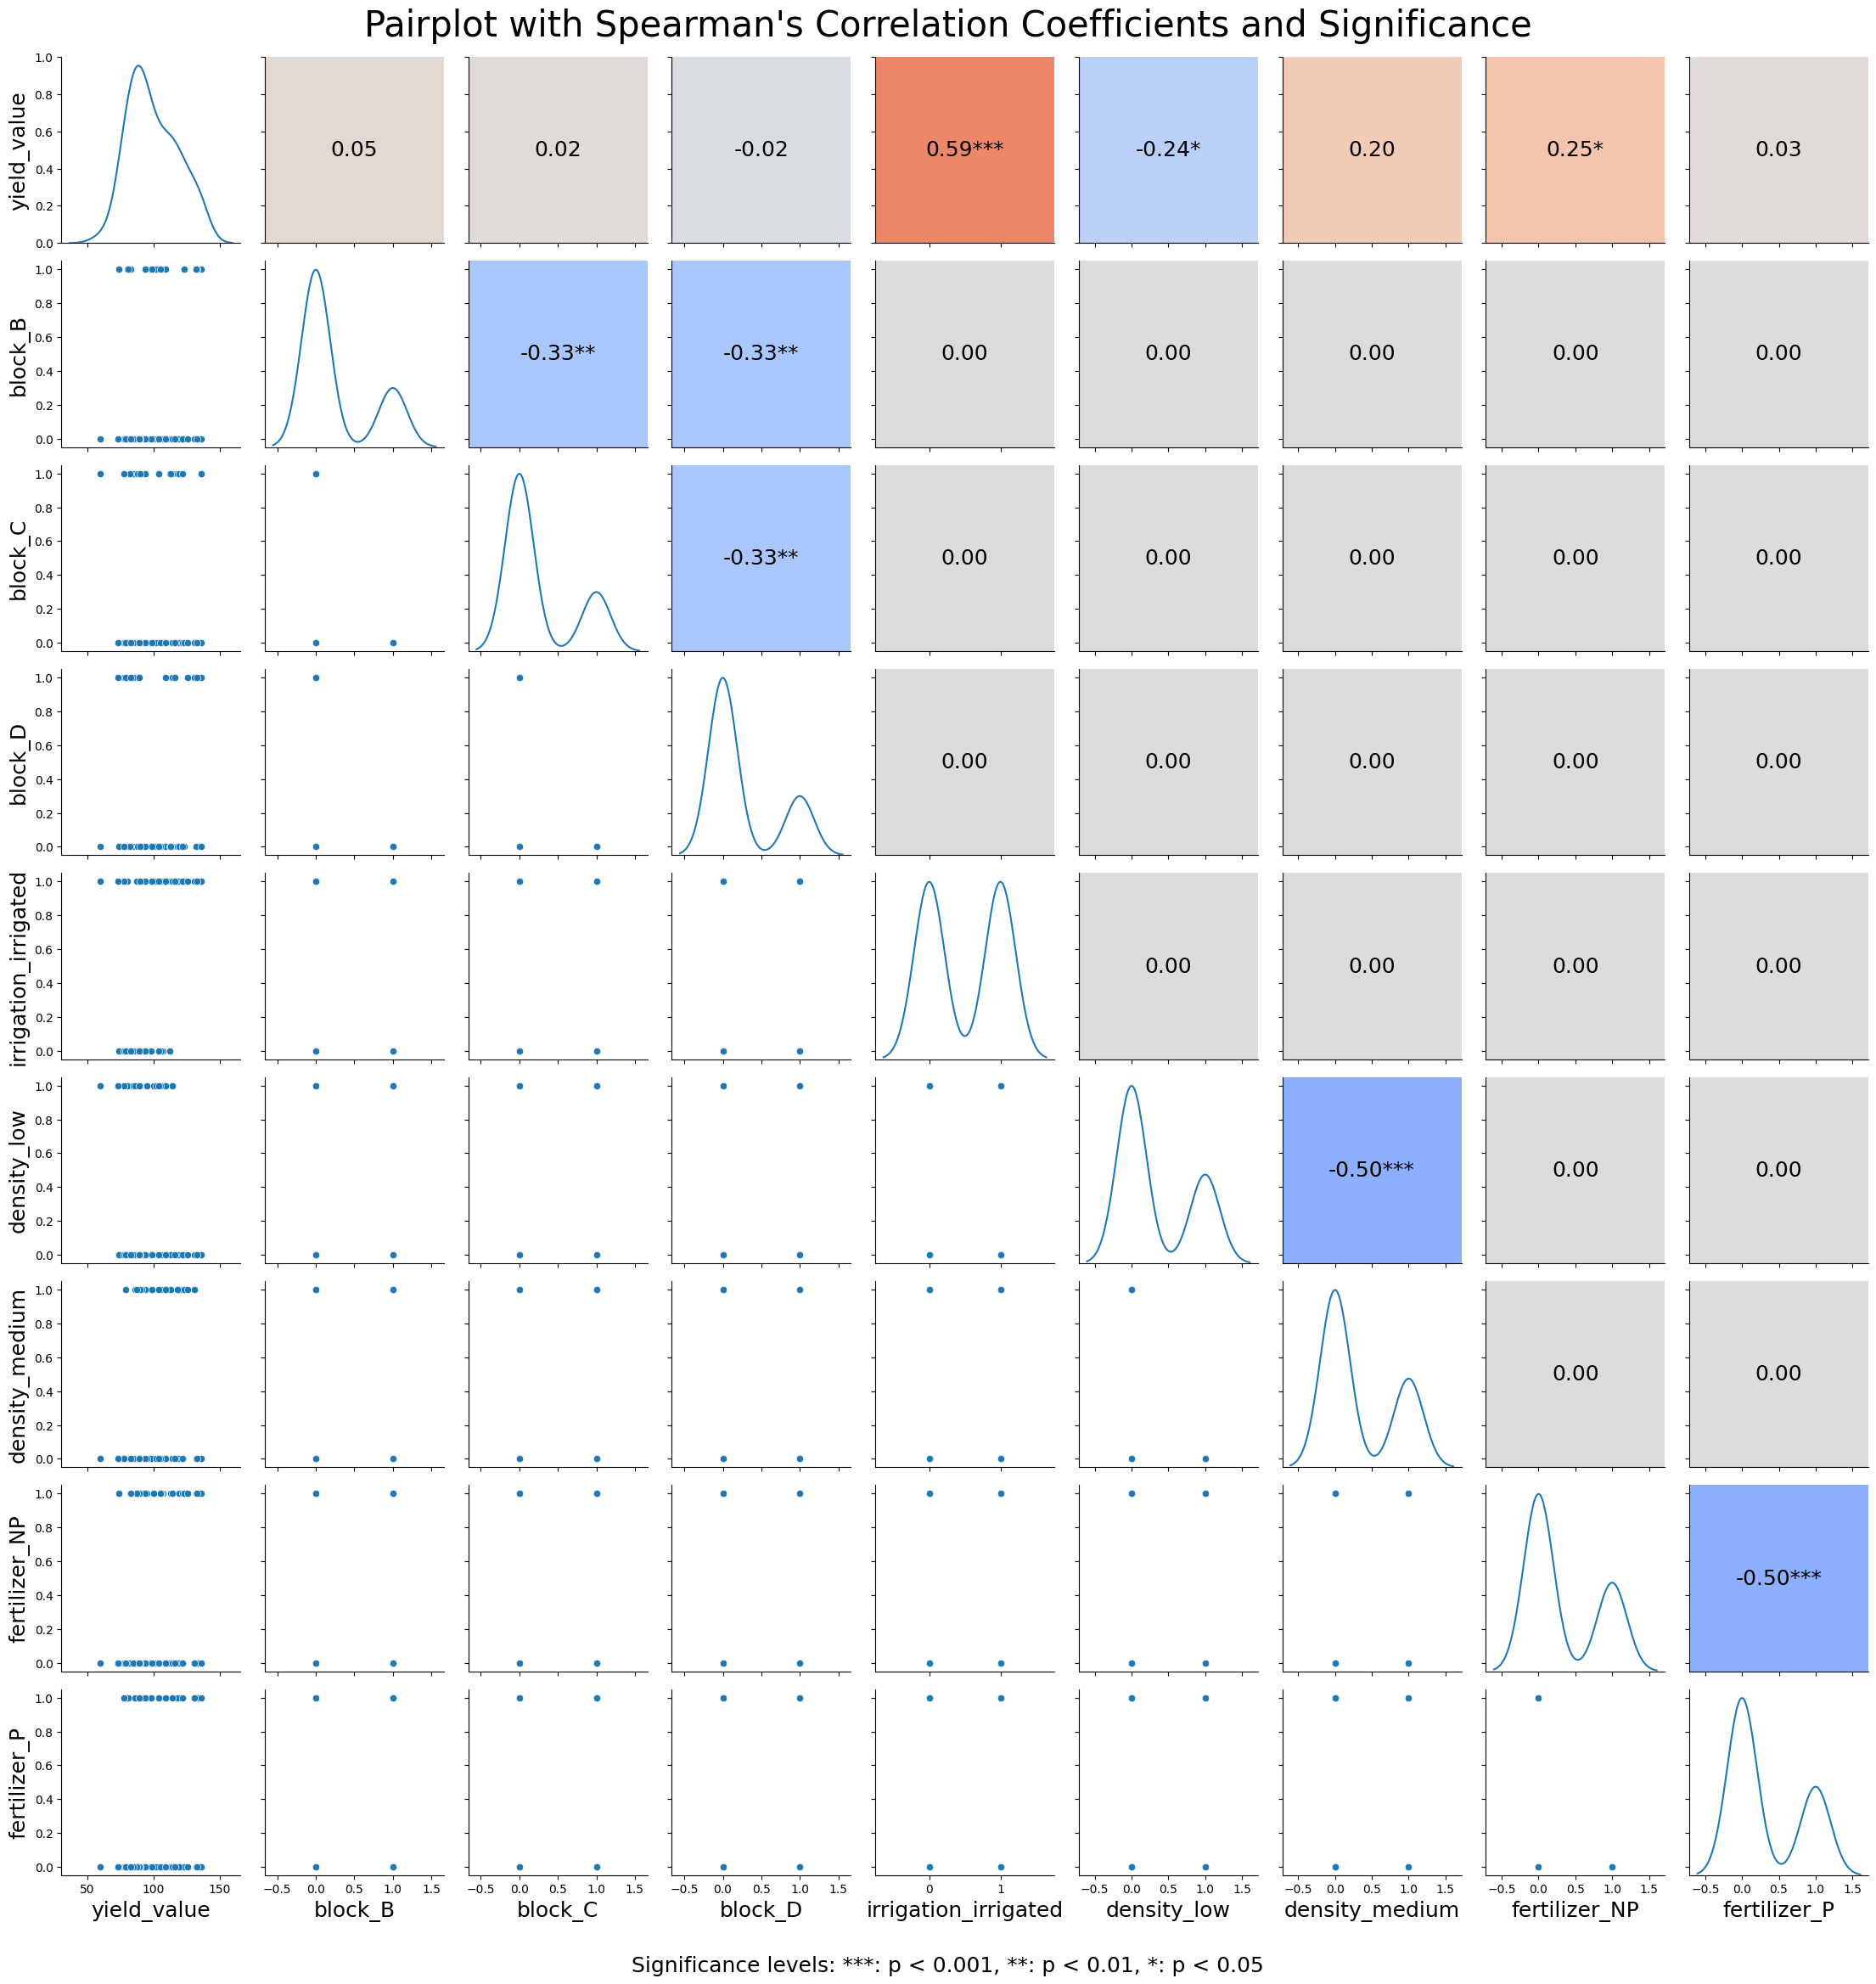

In [16]:
import scipy.stats as stats
# Function to annotate correlation coefficients and p-values in the upper triangle
def corr_coefficient_with_pval(x, y, **kwargs):
    coef, p_value = stats.spearmanr(x, y, nan_policy='omit')  # Calculate correlation coefficient and p-value
    ax = plt.gca()  # Get the current axis
    cmap = plt.cm.coolwarm  # Use coolwarm colormap
    color = cmap((coef + 1) / 2)  # Normalize correlation to range [0, 1] for colormap
    ax.set_facecolor(color)  # Set the face color of the subplot

    # Determine significance level
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    else:
        significance = ""

    # Annotate the coefficient and p-value with significance stars
    ax.annotate(f"{coef:.2f}{significance}", 
                xy=(0.5, 0.5), 
                xycoords=ax.transAxes, 
                ha="center", va="center", 
                fontsize=18, color="black")  # Adjust font size and color

# Create the pairplot
data_encoded.drop(columns=['yield_scaled'])
pairplot = sns.PairGrid(data_encoded.drop(columns=['yield_scaled']), diag_sharey=False)

# Map plots for each section of the PairGrid
pairplot.map_diag(sns.kdeplot)  # KDE on the diagonal to smooth out
pairplot.map_lower(sns.scatterplot)  # Scatter plots in lower triangle
pairplot.map_upper(corr_coefficient_with_pval)  # Correlation coefficients and p-values in upper triangle

# Customize the axes labels
for ax in pairplot.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)

# Add title
pairplot.fig.suptitle("Pairplot with Spearman's Correlation Coefficients and Significance", 
                      y=1.01, fontsize=30)

plt.figtext(0.5, -0.02, "Significance levels: ***: p < 0.001, **: p < 0.01, *: p < 0.05", 
            ha="center", va="bottom", fontsize=18, color="black")


# Save the plot if needed
# pairplot.fig.savefig("Pairplot_with_significance_and_legend.png", dpi=300, bbox_inches='tight')

plt.show()

Thankyou group 4 for above code :D

In [17]:
# VIF calculation
X = data_encoded.drop(columns=['yield_value', 'yield_scaled'])
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                Feature       VIF
0               block_B  1.555556
1               block_C  1.555556
2               block_D  1.555556
3  irrigation_irrigated  1.777778
4           density_low  1.666667
5        density_medium  1.666667
6         fertilizer_NP  1.666667
7          fertilizer_P  1.666667


VIF is < 5 for all Predictors

## Null Model

In [23]:
# Null model
null_model = smf.glm('yield_value ~ 1', data=data_encoded, family=sm.families.Poisson()).fit()
print(null_model.summary())
predictions = null_model.predict()
print("AIC", null_model.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            yield_value   No. Observations:                   72
Model:                            GLM   Df Residuals:                       71
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -349.21
Date:                Mon, 16 Dec 2024   Deviance:                       235.79
Time:                        22:50:32   Pearson chi2:                     238.
No. Iterations:                     4   Pseudo R-squ. (CS):         -7.572e-14
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6024      0.012    389.983      0.0

In [24]:
# Candidate GLMs
model_1 = smf.glm('yield_value ~ irrigation_irrigated + density_medium', data=data_encoded, family=sm.families.Poisson()).fit()
model_2 = smf.glm('yield_value ~ irrigation_irrigated + fertilizer_NP', data=data_encoded, family=sm.families.Poisson()).fit()
model_3 = smf.glm('yield_value ~ irrigation_irrigated + density_medium + fertilizer_NP', data=data_encoded, family=sm.families.Poisson()).fit()
model_4 = smf.glm('yield_value ~ irrigation_irrigated + density_medium + block_B', data=data_encoded, family=sm.families.Poisson()).fit()

models = {
    'Null Model': null_model,
    'Model 1': model_1,
    'Model 2': model_2,
    'Model 3': model_3,
    'Model 4': model_4,
}
# Create AIC table
aic_table = pd.DataFrame(
    {name: [model.aic] for name, model in models.items()},
    index=['AIC']
).T

# Sort AIC table by AIC value
aic_table = aic_table.sort_values(by='AIC')

print("\n--- AIC Table ---\n")
print(aic_table)


--- AIC Table ---

                   AIC
Model 3     605.159880
Model 2     608.623723
Model 1     615.795194
Model 4     617.255484
Null Model  700.425845


Best Model is Model 3 with AIC 605.15

## Residual Plots of all model

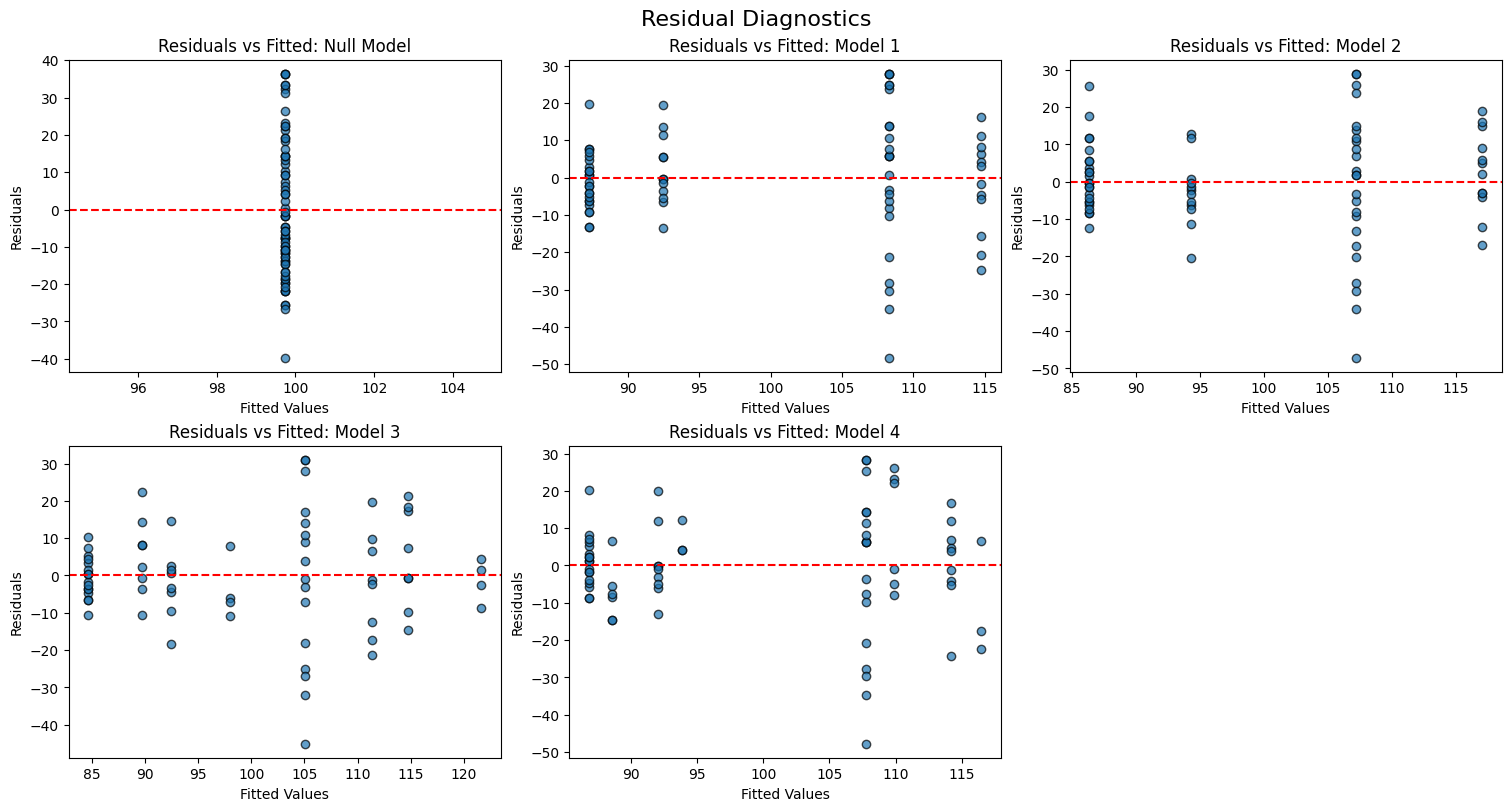

In [25]:
def plot_residuals(models_dict):
    num_models = len(models_dict)
    rows = 2  # Number of rows
    cols = (num_models + 1) // 2  # Calculate columns dynamically for 2 rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, 8), constrained_layout=True)
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, (name, model) in enumerate(models_dict.items()):
        # Residuals vs. Fitted
        axes[i].scatter(model.fittedvalues, model.resid_response, alpha=0.7, edgecolor="k")
        axes[i].axhline(0, color='red', linestyle='--')
        axes[i].set_title(f"Residuals vs Fitted: {name}")
        axes[i].set_xlabel("Fitted Values")
        axes[i].set_ylabel("Residuals")
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle("Residual Diagnostics", fontsize=16)
    plt.show()
    
plot_residuals(models)

## Data splitting

                 Generalized Linear Model Regression Results                  
Dep. Variable:            yield_value   No. Observations:                   64
Model:                            GLM   Df Residuals:                       60
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -266.63
Date:                Mon, 16 Dec 2024   Deviance:                       121.94
Time:                        22:51:03   Pearson chi2:                     119.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.7604
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.4341 

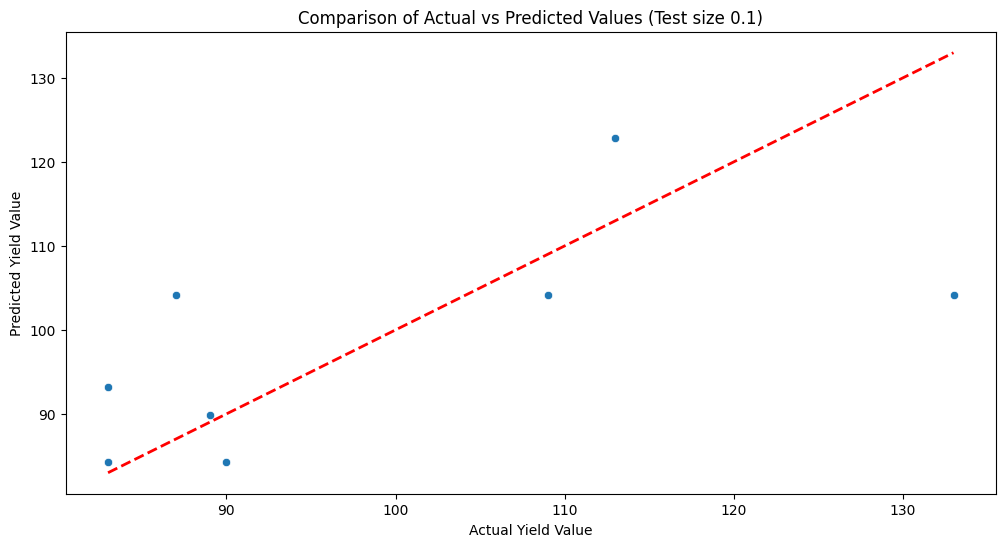

                 Generalized Linear Model Regression Results                  
Dep. Variable:            yield_value   No. Observations:                   50
Model:                            GLM   Df Residuals:                       46
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -196.22
Date:                Mon, 16 Dec 2024   Deviance:                       70.933
Time:                        22:51:04   Pearson chi2:                     69.5
No. Iterations:                     4   Pseudo R-squ. (CS):             0.8385
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.4345 

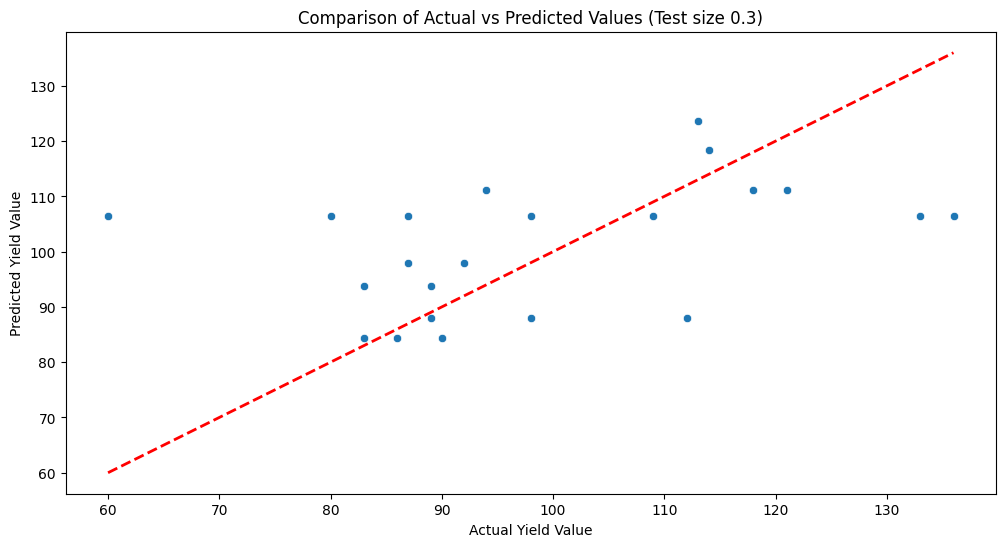

                 Generalized Linear Model Regression Results                  
Dep. Variable:            yield_value   No. Observations:                   36
Model:                            GLM   Df Residuals:                       32
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -145.98
Date:                Mon, 16 Dec 2024   Deviance:                       60.379
Time:                        22:51:04   Pearson chi2:                     59.1
No. Iterations:                     4   Pseudo R-squ. (CS):             0.8049
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.4352 

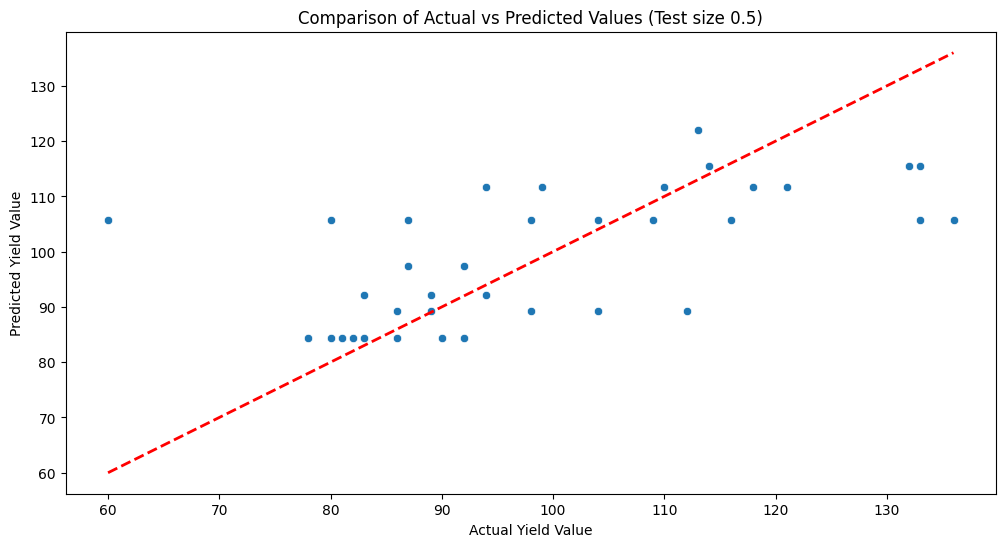

Evaluating MSE for different splits (AIC of Model 3)...

MSE Scores for Different Splits:
Train:Test Split 10:90 -> MSE: 173.1531
Train:Test Split 30:70 -> MSE: 293.7411
Train:Test Split 50:50 -> MSE: 206.8647


In [26]:
test_sizes = [0.1, 0.3, 0.5]
model_used, model_aic, model_deviance = [], [], []
mse_results = {}
for size in test_sizes:

    # data splitting
    X_train, X_test, y_train, y_test = train_test_split(data_encoded.drop(columns=['yield_value']), data_encoded['yield_value'], test_size=size, random_state=42)

    # getting all the training data together
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    # train model 3
    formula = 'yield_value ~ irrigation_irrigated + density_medium + fertilizer_NP'
    model = smf.glm(formula, train, family = sm.families.Poisson())
    result = model.fit()
    print(result.summary())
    model_used.append('Model 3')
    model_aic.append(result.aic)
    model_deviance.append(result.deviance)
    print("The result of the AIC is: ")
    print(round(result.aic,2))

    # calculate explained deviance
    residual_deviance = result.deviance
    null_deviance = result.null_deviance
    deviance_explained = 1 - (residual_deviance / null_deviance)
    print(f"Explained Deviance (Training Data): {deviance_explained:.4f}")

    # predict on test data
    y_predict = result.predict(X_test)
    test_predict = pd.concat([y_test, y_predict], axis=1)
    test_predict = test_predict.reset_index(drop=True)
    test_predict = test_predict.rename(columns={"yield_value": "Actual Yield Value", 0: "Predicted Yield Value"})
    mse_score = mean_squared_error(y_test, y_predict)
    mse_results[f"{int(size * 100)}:{int((1 - size) * 100)}"] = mse_score

    # plot actual vs predicted
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=test_predict, x="Actual Yield Value", y="Predicted Yield Value")
    # Add a diagonal line where actual = predicted
    max_val = max(test_predict["Actual Yield Value"].max(), test_predict["Predicted Yield Value"].max())
    min_val = min(test_predict["Actual Yield Value"].min(), test_predict["Predicted Yield Value"].min())
    plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=2, label="Actual = Predicted")
    plt.title(f"Comparison of Actual vs Predicted Values (Test size {size})")
    plt.show()

print("Evaluating MSE for different splits (AIC of Model 3)...")
# Display the results
print("\nMSE Scores for Different Splits:")
for split, mse in mse_results.items():
    print(f"Train:Test Split {split} -> MSE: {mse:.4f}")

## Residual of Model 3 after spliting

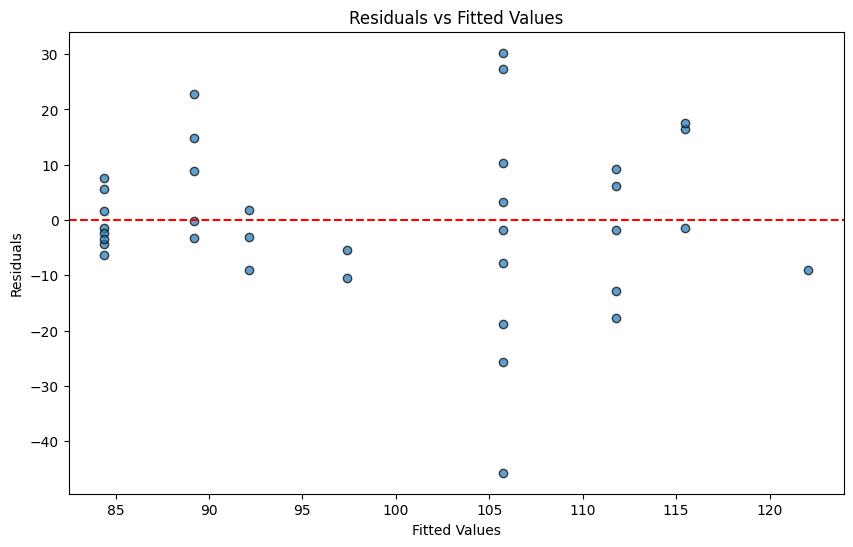

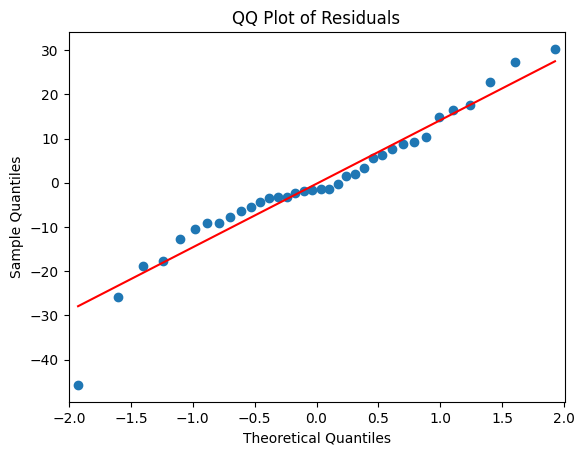

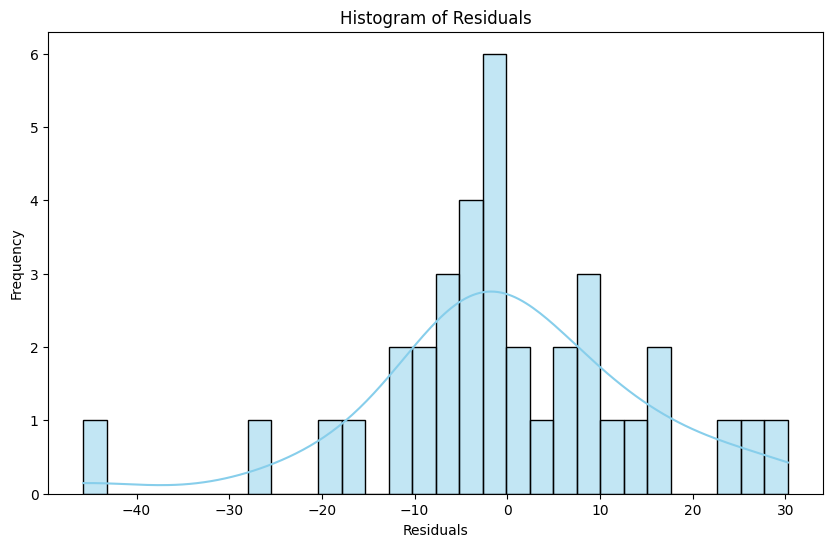

In [28]:
# Get residuals from Model 3
y = data_encoded['yield_value']
X_train, X_test, y_train, y_test = train_test_split(data_encoded.drop(columns=['yield_value']), data_encoded['yield_value'], test_size=0.5, random_state=42)
y_predict = result.predict(X_test) # Predicted values
residuals = y_test - y_predict  # Residuals (actual - predicted)

# Residuals vs Fitted values plot
plt.figure(figsize=(10, 6))
plt.scatter(y_predict, residuals, alpha=0.7, edgecolor="k")
plt.axhline(0, color='red', linestyle='--')  # Horizontal line at zero
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

# QQ plot to check for normality of residuals
sm.qqplot(residuals, line='s')
plt.title("QQ Plot of Residuals")
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Conclusion

* Model 3 (with the formula yield_value ~ irrigation_irrigated + density_medium + fertilizer_NP) is the best-performing model based on AIC, suggesting it offers the best balance between predictive accuracy and model complexity.
* The MSE results suggest that the model generalizes better as the training set size increases (from 10% to 50%).